### Set Up

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential 
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = 'train'
test_path = 'test'
valid_path = 'valid'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=3)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
# Plots images with labels
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
        f = plt.figure(figsize=figsize)
        cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i + 1)
            sp.axis('Off')
            if titles is not None:
                sp.set_title(titles[i], fontsize=16)
            plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

C:\Users\Joseph.Akayesi\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


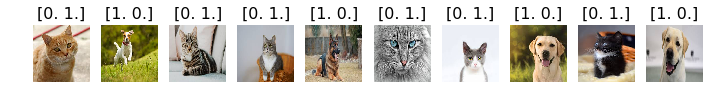

In [6]:
plots(imgs, titles=labels)

## Build and Train CNN

In [7]:
model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            Flatten(),
            Dense(2, activation='softmax')
        ])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 3s - loss: 7.2844 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 7.6561 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 1s - loss: 6.0443 - acc: 0.6250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 1s - loss: 8.4620 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 2s - loss: 8.8650 - acc: 0.4500 - val_loss: 8.0590 - val_acc: 0.5000


## Prediction

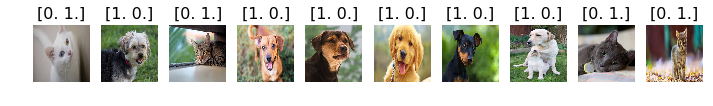

In [10]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [11]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 0.], dtype=float32)

In [12]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [13]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
cm = confusion_matrix(test_labels, predictions[:, 0])

In [15]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    ''' 
    This function prints can plots the confusion matrix. 
    Normalization can be applied by setting Normalization=True
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalize confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[0 4]
 [0 6]]


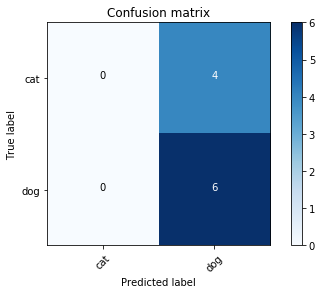

In [16]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix')

## Build a fine-tuned VGG16 model

In [17]:
 vgg16_model = keras.applications.vgg16.VGG16()

In [18]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
type(vgg16_model)

keras.engine.training.Model

In [20]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [22]:
# pop model not working. Should enable this when for layer in vgg16_model.layers: 
# model.layers.pop()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [24]:
for layer in model.layers:
    layer.trainable = False

In [25]:
model.add(Dense(2, activation='softmax'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

   ## Train the fine-tuned VGG16 model

In [27]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 31s - loss: 0.7053 - acc: 0.7250 - val_loss: 0.3346 - val_acc: 0.7500
Epoch 2/5
 - 28s - loss: 0.5181 - acc: 0.8250 - val_loss: 0.1889 - val_acc: 0.9167
Epoch 3/5
 - 34s - loss: 0.3545 - acc: 0.8500 - val_loss: 0.1412 - val_acc: 0.9167
Epoch 4/5
 - 24s - loss: 0.2496 - acc: 0.8750 - val_loss: 0.0254 - val_acc: 1.0000
Epoch 5/5
 - 27s - loss: 0.1732 - acc: 0.9500 - val_loss: 0.1325 - val_acc: 0.8333
